In [19]:
import torch
from torch import nn
import torchaudio
from torch.utils.data import Dataset, DataLoader
import os
import random

# Define the RNN-based model for speaker recognition (using LSTM)
class SpeakerRNN(nn.Module):
    def __init__(self, num_classes):
        super(SpeakerRNN, self).__init__()
        
        # LSTM-based RNN layers
        self.lstm = nn.LSTM(
            input_size=64,   # Number of Mel bins (same as n_mels in your config)
            hidden_size=128, # Number of LSTM hidden units
            num_layers=2,    # Two LSTM layers
            batch_first=True,  # Input shape: [batch, time_steps, features]
            dropout=0.2       # Dropout between LSTM layers
        )
        
        # Fully connected layers
        self.fc1 = nn.Linear(128, 128)    # First fully connected layer
        self.fc2 = nn.Linear(128, num_classes)  # Output layer (10 classes for 10 speakers)

    def forward(self, x):
        # Pass the input through the LSTM layers
        x, (hn, cn) = self.lstm(x)  # Output and hidden state
        x = x[:, -1, :]  # Use the last output of LSTM (last time step)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = self.fc2(x)
        
        return x

# Dataset preparation (LibriSpeech)
class LibriSpeechSpeakerDataset(Dataset):
    def __init__(self, root_dir, speaker_to_idx, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.speaker_to_idx = speaker_to_idx
        self.target_length = 800  # Fixed number of time steps (adjustable)

        for spk in speaker_to_idx.keys():
            spk_dir = os.path.join(root_dir, spk)
            for chapter in os.listdir(spk_dir):
                chapter_dir = os.path.join(spk_dir, chapter)
                for file in os.listdir(chapter_dir):
                    if file.endswith(".flac"):
                        self.samples.append({
                            "path": os.path.join(chapter_dir, file),
                            "label": speaker_to_idx[spk]
                        })

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        waveform, sample_rate = torchaudio.load(sample["path"])

        # Resample to 16kHz if needed
        if sample_rate != 16000:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
            waveform = resampler(waveform)

        # Convert to Mel spectrogram (shape: [1, 64, time])
        mel_spec = torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=64)(waveform)
        mel_db = torchaudio.transforms.AmplitudeToDB()(mel_spec).squeeze(0)  # shape: [64, time]

        # Pad or trim to fixed width (target_length = 800)
        if mel_db.shape[1] > self.target_length:
            mel_db = mel_db[:, :self.target_length]
        else:
            pad_width = self.target_length - mel_db.shape[1]
            mel_db = torch.nn.functional.pad(mel_db, (0, pad_width))
        
        mel_db = mel_db.T  # Transpose to [time, features] for LSTM

        return mel_db, sample["label"]

# Prepare dataset and dataloaders
LIBRISPEECH_DIR = "Data/TestDS/"
speakers = os.listdir(LIBRISPEECH_DIR)
speaker_to_idx = {speaker: idx for idx, speaker in enumerate(speakers)}

# Create dataset
dataset = LibriSpeechSpeakerDataset(root_dir=LIBRISPEECH_DIR, speaker_to_idx=speaker_to_idx)

# To get all the labels and ensure correct range of labels
all_labels = [sample["label"] for sample in dataset.samples]
print(f"Max label value: {max(all_labels)}")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)

# Model, loss, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SpeakerRNN(num_classes=len(speaker_to_idx))  # Dynamically using number of classes
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for mel, labels in train_loader:
        mel = mel.to(device)  # shape: [batch_size, time_steps, features]
        labels = labels.to(device)

        outputs = model(mel)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {avg_loss:.4f}, Accuracy: {acc:.2f}%")

# Evaluation on validation set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, labels in val_loader:
        mel, labels = mel.to(device), labels.to(device)
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Validation Accuracy: {100 * correct / total:.2f}%")

Max label value: 9
Epoch [1/10] - Loss: 2.1468, Accuracy: 26.07%
Epoch [2/10] - Loss: 1.5012, Accuracy: 49.76%
Epoch [3/10] - Loss: 1.2963, Accuracy: 53.45%
Epoch [4/10] - Loss: 1.0492, Accuracy: 61.43%
Epoch [5/10] - Loss: 0.9836, Accuracy: 61.19%
Epoch [6/10] - Loss: 0.9073, Accuracy: 65.00%
Epoch [7/10] - Loss: 0.8900, Accuracy: 65.60%
Epoch [8/10] - Loss: 1.0921, Accuracy: 61.90%
Epoch [9/10] - Loss: 0.8329, Accuracy: 68.93%
Epoch [10/10] - Loss: 0.9390, Accuracy: 73.81%
Validation Accuracy: 67.62%


In [24]:
# Split dataset into train, validation, and test
train_size = int(0.6 * len(dataset))  # 70% for training
val_size = int(0.2 * len(dataset))    # 20% for validation
test_size = len(dataset) - train_size - val_size  # 10% for testing

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader = DataLoader(val_set, batch_size=32)
test_loader = DataLoader(test_set, batch_size=32)  # Define test loader

# Now you can evaluate on the test set
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mel, labels in test_loader:  # Using test_loader here
        mel, labels = mel.to(device), labels.to(device)
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Test Accuracy: 71.43%


In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# After evaluating on the validation set
model.eval()  # Switch model to evaluation mode
correct = 0
total = 0
all_labels = []
all_preds = []

with torch.no_grad():
    for mel, labels in test_loader:    # val
        mel, labels = mel.to(device), labels.to(device)
        
        outputs = model(mel)
        _, predicted = torch.max(outputs, 1)
        
        all_labels.extend(labels.cpu().numpy())  # Store actual labels
        all_preds.extend(predicted.cpu().numpy())  # Store predicted labels

        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate accuracy
accuracy = accuracy_score(all_labels, all_preds)

# Calculate precision, recall, and f1-score (for multi-class classification)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print metrics
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")
print(f"F1 Score: {f1 * 100:.2f}%")

# Optionally, print detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))


Accuracy: 71.43%
Precision: 82.64%
Recall: 71.43%
F1 Score: 72.99%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.57      0.36      0.44        22
           2       0.83      0.77      0.80        13
           3       1.00      0.92      0.96        26
           4       0.38      1.00      0.55        29
           5       1.00      0.75      0.86        16
           6       1.00      0.68      0.81        22
           7       1.00      0.73      0.84        26
           8       0.83      0.38      0.53        26
           9       0.78      0.64      0.70        11

    accuracy                           0.71       210
   macro avg       0.84      0.71      0.74       210
weighted avg       0.83      0.71      0.73       210



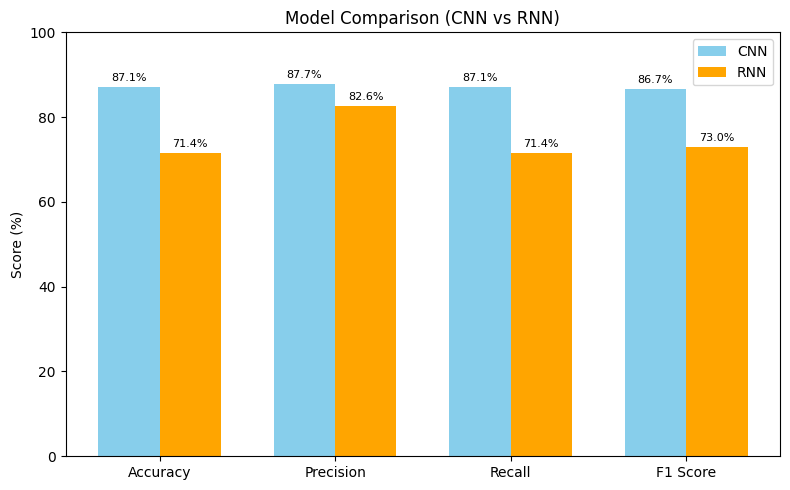

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Sample metric values — replace with your real results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
cnn_scores = [87.14, 87.72, 87.14, 86.71] 
rnn_scores = [71.43, 82.64, 71.43, 72.99]  

x = np.arange(len(metrics))  # label locations
width = 0.35  # bar width

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, cnn_scores, width, label='CNN', color='skyblue')
bars2 = ax.bar(x + width/2, rnn_scores, width, label='RNN', color='orange')

# Add text labels on top of bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

# Customize plot
ax.set_ylabel('Score (%)')
ax.set_title('Model Comparison (CNN vs RNN)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 100)
ax.legend()
plt.tight_layout()
plt.show()
